In [2]:
import numpy as np
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta, self.mean, self.std_dev = theta, mean, std_deviation
        self.dt, self.x_initial = dt, x_initial
        self.reset()
    def __call__(self):
        x = (self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt +
             self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape))
        self.x_prev = x
        return x
    def reset(self):
        self.x_prev = self.x_initial if self.x_initial is not None else np.zeros_like(self.mean)

class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        self.buffer_capacity, self.batch_size = buffer_capacity, batch_size
        self.buffer_counter = 0
        self.state_buffer = np.zeros((buffer_capacity, num_states))
        self.action_buffer = np.zeros((buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((buffer_capacity, 1))
        self.next_state_buffer = np.zeros((buffer_capacity, num_states))
    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity
        (self.state_buffer[index], self.action_buffer[index],
         self.reward_buffer[index], self.next_state_buffer[index]) = obs_tuple
        self.buffer_counter += 1
    #@tf.function
    def update(self, actor_model, critic_model, target_actor, target_critic, actor_optimizer, critic_optimizer,state_batch, action_batch, reward_batch, next_state_batch):
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions], training=True)
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.reduce_mean(tf.square(y - critic_value))
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(zip(critic_grad, critic_model.trainable_variables))
        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            actor_loss = -tf.reduce_mean(critic_value)
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(zip(actor_grad, actor_model.trainable_variables))
    def learn(self, actor_model, critic_model, target_actor, target_critic, actor_optimizer, critic_optimizer):
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.cast(tf.convert_to_tensor(self.reward_buffer[batch_indices]), dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        self.update(actor_model, critic_model, target_actor, target_critic,actor_optimizer,critic_optimizer,state_batch, action_batch, reward_batch, next_state_batch)

@tf.function
def update_target(target_weights, weights, tau):
    for a, b in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

def get_actor():
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic():
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)
    concat = layers.Concatenate()([state_out, action_out])
    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)
    model = tf.keras.Model([state_input, action_input], outputs)
    return model

def policy(state, noise_object, actor_model, lower_bound, upper_bound):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    sampled_actions = sampled_actions.numpy() + noise
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)
    return [np.squeeze(legal_action)]

class MultiAgentTradingEnv(gym.Env):
    def __init__(self, db, nsteps):
        self.rnd = 0
        self.lower_bound = 0.0
        self.upper_bound = 1.0
        self.period = -1
        self.nperiods = nperiods
        self.db = db
        self.action_space = gym.spaces.Box(0, 1, (1,), dtype=np.float32)  # Continuous action space [0, 1]
        self.observation_space = gym.spaces.Box(-1, 200, (1,), dtype=np.float32)  # Continuous state space

    def reset(self):
        self.db.reset_period(self.rnd)
        self.timestep = 0
        self.period += 1
        [buyer.next_token() for buyer in self.db.buyers]
        [seller.next_token() for seller in self.db.sellers]
        observations = []
        for agent_idx in range(4):
            if agent_idx<2:
                agent = self.db.buyers[agent_idx]
            else:
                agent_idx = agent_idx - 2
                agent = self.db.buyers[agent_idx]
            if information == 0:
                # environmental
                observation = np.array([self.timestep + 1, agent.value, agent.step_profit,
                                        agent.sale, agent.num_tokens_traded], dtype=np.float32)
            elif information == 1:
                # environmental + winning
                data = [self.timestep + 1, -1, -1, agent.value,
                        agent.step_profit, agent.sale, agent.num_tokens_traded]
                observation = np.array(data, dtype=np.float32)                
            elif information == 2:
                # environmental + winning + log
                data = [self.timestep + 1, -1,  -1,  -1,
                         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1, 
                         -1,  -1,  -1, agent.value,
                        agent.step_profit, agent.sale, agent.num_tokens_traded]
                observation = np.array(data, dtype=np.float32)
            elif information == 3: 
                buyer_tokens = [0 for i in self.db.buyers]
                seller_tokens = [0 for i in self.db.sellers]
                buyer_sale = [-1 for i in self.db.buyers]
                seller_sale = [-1 for i in self.db.sellers]
                data = [self.timestep + 1,  -1,  -1,  -1,
                         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1, 
                         -1,  -1,  -1, agent.value,
                        agent.step_profit, agent.sale, agent.num_tokens_traded]
                data = data + [-1]*self.db.nbuyers + [-1]*self.db.nsellers + buyer_tokens + buyer_sale + seller_tokens + seller_sale
                observation = np.array(data, dtype=np.float32)         
            idx = np.isnan(observation)
            observation[idx] = -1.0
            observations.append(observation)
        return observations  # Return continuous state

    def step(self, action0, action1, seller_action0, seller_action1):
        global information
        [buyer.next_token() for buyer in self.db.buyers]
        [seller.next_token() for seller in self.db.sellers]
        
        # bidder0
        bid_frac = np.clip(action0, self.lower_bound, self.upper_bound)
        self.db.buyers[0].next_token()
        min_bid = self.db.buyers[0].value * min_frac
        max_bid = self.db.buyers[0].value * max_frac
        bid0 = np.round(max_bid * bid_frac + (1 - bid_frac) * min_bid, 2)

        # bidder1
        bid_frac = np.clip(action1, self.lower_bound, self.upper_bound)
        self.db.buyers[1].next_token()
        min_bid = self.db.buyers[1].value * min_frac
        max_bid = self.db.buyers[1].value * max_frac
        bid1 = np.round(max_bid * bid_frac + (1 - bid_frac) * min_bid, 2)

        # seller0
        ask_frac = np.clip(seller_action0, self.lower_bound, self.upper_bound)
        self.db.sellers[0].next_token()
        min_ask = self.db.sellers[0].value * min_frac
        min_ask = self.db.sellers[0].value * max_frac
        ask0 = np.round(min_ask * ask_frac + (1 - ask_frac) * min_ask, 2)

        # seller0
        ask_frac = np.clip(seller_action1, self.lower_bound, self.upper_bound)
        self.db.sellers[1].next_token()
        min_ask = self.db.sellers[1].value * min_frac
        min_ask = self.db.sellers[1].value * max_frac
        ask1 = np.round(min_ask * ask_frac + (1 - ask_frac) * min_ask, 2)

        # Simulate market
        bids = [buyer.bid(self.db) for buyer in self.db.buyers]
        bids[0] = bid0.item()
        bids[1] = bid1.item()
        asks = [seller.ask(self.db) for seller in self.db.sellers]
        asks[0] = ask0.item()
        asks[1] = ask1.item()
        current_ask, current_ask_idx, current_bid, current_bid_idx = current_bid_ask(bids, asks)
        sale, price, bprofit, sprofit, buy, sell = buy_sell(self.db, current_bid, current_bid_idx, current_ask,
                                                           current_ask_idx)
        step_data = [self.rnd, self.period, self.timestep, bids, asks, current_bid, current_bid_idx, current_ask,
                     current_ask_idx, buy, sell, price, sale, bprofit, sprofit]
        self.db.add_step(step_data)

        # REWARDS
        reward0 = 0.0
        reward1 = 0.0
        seller_reward0 = 0.0
        seller_reward1 = 0.0
        if sale == 1:
            if current_bid_idx == 0:
                reward0 = bprofit
            if current_bid_idx == 1:
                reward1 = bprofit 
            if current_ask_idx == 0:
                seller_reward0 = sprofit
            if current_ask_idx == 1:
                seller_reward1 = sprofit    
        rewards = [reward0,reward1,seller_reward0,seller_reward1]
                
        # STATES
        observations = []
        for agent_idx in range(4):
            if agent_idx<2:
                agent = self.db.buyers[agent_idx]
            else:
                agent_idx = agent_idx - 2
                agent = self.db.buyers[agent_idx]
            if information == 0:
                # environmental
                observation = np.array([self.timestep + 1, agent.value, agent.step_profit,
                                        agent.sale, agent.num_tokens_traded], dtype=np.float32)
            elif information == 1:
                # environmental + winning
                data = [self.timestep + 1, sale, price, agent.value,
                        agent.step_profit, agent.sale, agent.num_tokens_traded]
                observation = np.array(data, dtype=np.float32)                
            elif information == 2:
                # environmental + winning + log
                data = [self.timestep + 1, current_ask, current_ask_idx, current_bid,
                        current_bid_idx, sale, price, buy, sell, np.min(bids), np.max(bids), np.mean(bids), 
                        np.min(asks), np.max(asks), np.mean(asks), agent.value,
                        agent.step_profit, agent.sale, agent.num_tokens_traded]
                observation = np.array(data, dtype=np.float32)
            elif information == 3: 
                buyer_tokens = [i.num_tokens_traded for i in self.db.buyers]
                seller_tokens = [i.num_tokens_traded for i in self.db.sellers]
                buyer_sale = [i.sale for i in self.db.buyers]
                seller_sale = [i.sale for i in self.db.sellers]
                data = [self.timestep + 1, current_ask, current_ask_idx, current_bid,
                        current_bid_idx, sale, price, buy, sell, np.min(bids), np.max(bids), np.mean(bids), 
                        np.min(asks), np.max(asks), np.mean(asks), agent.value,
                        agent.step_profit, agent.sale, agent.num_tokens_traded]
                data2 = data + bids + asks + buyer_tokens + buyer_sale + seller_tokens + seller_sale
                observation = np.array(data2, dtype=np.float32)         
            idx = np.isnan(observation)
            observation[idx] = -1.0
            observations.append(observation)
            
        # Check termination
        self.timestep += 1
        terminated = self.timestep == nsteps
        truncated = terminated  # Truncated episodes are not used in DDPG

        return observations, rewards, terminated, {}
                         
import numpy as np
from functions import *
from itertools import count
buyer_strategies = ['Honest','Honest']
seller_strategies = ['Honest','Honest']
nbuyers, nsellers = len(buyer_strategies), len(seller_strategies)
nrounds, nperiods, ntokens, nsteps, gametype, nbuyers, nsellers = 10, 10, 4, 16, '1234', len(buyer_strategies), len(seller_strategies)
R1, R2, R3, R4 = gametype_to_ran(gametype)
game_metadata = [nrounds, nperiods, ntokens, nbuyers, nsellers, nsteps, R1, R2, R3, R4]
num_iterations = 1

for iteration in range(num_iterations):
    information = np.random.choice([0,1,2,3])
    db = Database(game_metadata, buyer_strategies, seller_strategies)
    rnd = 0
    period = 0
    min_frac = 0.01
    max_frac = 1.0
    db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
    db.round_data.token_costs = [np.array([
        [48.7, 62.4, 64.4, 69.7, 73.9, 88.0, 89.9, 100.2],
        [47.4, 65.1, 68.8, 71.5, 79.0, 84.7, 85.8, 102.9]])]
    db.round_data.redemption_values = [np.array([
        [93.4, 75.3, 72.4, 64.0, 60.9, 59.6, 48.7, 24.6],
        [95.1, 94.9, 81.9, 77.3, 75.3, 63.5, 42.3, 20.2]])]
    env = MultiAgentTradingEnv(db,nsteps)
    _, num_actions = env.observation_space.shape[0], env.action_space.shape[0]
    upper_bound, lower_bound = env.action_space.high[0], env.action_space.low[0]
    
    if information == 0:
        num_states = 5
    elif information == 1:
        num_states = 7
    elif information == 2:
        num_states = 19
    elif information == 3:
        num_states = 31    

    # Common parameters
    std_dev = 0.2
    total_episodes = 1000
    gamma = 0.99
    tau = 0.005
    critic_lr = 0.002
    actor_lr = 0.001

    # Noise
    ou_noise0 = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
    ou_noise1 = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
    seller_ou_noise0 = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
    seller_ou_noise1 = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

    # Agent 1
    actor_model0 = get_actor()
    critic_model0 = get_critic()
    target_actor0 = get_actor()
    target_critic0 = get_critic()
    target_actor0.set_weights(actor_model0.get_weights())
    target_critic0.set_weights(critic_model0.get_weights())
    critic_optimizer0 = tf.keras.optimizers.Adam(critic_lr)
    actor_optimizer0 = tf.keras.optimizers.Adam(actor_lr)
    buffer0 = Buffer(50000, 64)
    ep_reward_list0, avg_reward_list0 = [], []

    # Agent 2
    actor_model1 = get_actor()
    critic_model1 = get_critic()
    target_actor1 = get_actor()
    target_critic1 = get_critic()
    target_actor1.set_weights(actor_model1.get_weights())
    target_critic1.set_weights(critic_model1.get_weights())
    critic_optimizer1 = tf.keras.optimizers.Adam(critic_lr)
    actor_optimizer1 = tf.keras.optimizers.Adam(actor_lr)
    buffer1 = Buffer(50000, 64)
    ep_reward_list1, avg_reward_list1 = [], []

    # Agent 3 (Seller 1)
    seller_actor_model0 = get_actor()
    seller_critic_model0 = get_critic()
    seller_target_actor0 = get_actor()
    seller_target_critic0 = get_critic()
    seller_target_actor0.set_weights(seller_actor_model0.get_weights())
    seller_target_critic0.set_weights(seller_critic_model0.get_weights())
    seller_critic_optimizer0 = tf.keras.optimizers.Adam(critic_lr)
    seller_actor_optimizer0 = tf.keras.optimizers.Adam(actor_lr)
    seller_buffer0 = Buffer(50000, 64)
    seller_ep_reward_list0, seller_avg_reward_list0 = [], []

    # Agent 4 (Seller 2)
    seller_actor_model1 = get_actor()
    seller_critic_model1 = get_critic()
    seller_target_actor1 = get_actor()
    seller_target_critic1 = get_critic()
    seller_target_actor1.set_weights(seller_actor_model1.get_weights())
    seller_target_critic1.set_weights(seller_critic_model1.get_weights())
    seller_critic_optimizer1 = tf.keras.optimizers.Adam(critic_lr)
    seller_actor_optimizer1 = tf.keras.optimizers.Adam(actor_lr)
    seller_buffer1 = Buffer(50000, 64)
    seller_ep_reward_list1, seller_avg_reward_list1 = [], []

    total_episodes = 1
    for ep in range(total_episodes):
        prev_state0, prev_state1, seller_prev_state0, seller_prev_state1 = env.reset()
        episodic_reward0, episodic_reward1, seller_episodic_reward0, seller_episodic_reward1 = 0, 0,0,0

        while True:
            tf_prev_state0 = tf.expand_dims(tf.convert_to_tensor(prev_state0), 0)
            tf_prev_state1 = tf.expand_dims(tf.convert_to_tensor(prev_state1), 0)
            tf_seller_prev_state0 = tf.expand_dims(tf.convert_to_tensor(seller_prev_state0), 0)
            tf_seller_prev_state1 = tf.expand_dims(tf.convert_to_tensor(seller_prev_state1), 0)

            # actions
            action0 = policy(tf_prev_state0, ou_noise0, actor_model0, lower_bound, upper_bound)
            action1 = policy(tf_prev_state1, ou_noise1, actor_model1, lower_bound, upper_bound)
            seller_action0 = policy(tf_seller_prev_state0, seller_ou_noise0, seller_actor_model0, lower_bound, upper_bound)
            seller_action1 = policy(tf_seller_prev_state1, seller_ou_noise1, seller_actor_model1, lower_bound, upper_bound)

            # Play game
            observations, rewards, done, info = env.step(action0, action1, seller_action0, seller_action1)
            [state0, state1, seller_state0, seller_state1] = observations
            [reward0, reward1, seller_reward0, seller_reward1] = rewards
            
            # Record
            buffer0.record((prev_state0, action0, reward0, state0))
            buffer1.record((prev_state1, action1, reward1, state1))
            seller_buffer0.record((prev_state0, seller_action0, seller_reward0, seller_state0))
            seller_buffer1.record((prev_state1, seller_action1, seller_reward1, seller_state1))

            # Episodic rewards
            episodic_reward0 += reward0
            episodic_reward1 += reward1
            seller_episodic_reward0 += seller_reward0
            seller_episodic_reward1 += seller_reward1

            # Training
            buffer0.learn(actor_model0, critic_model0, target_actor0, target_critic0, actor_optimizer0, critic_optimizer0)
            buffer1.learn(actor_model1, critic_model1, target_actor1, target_critic1, actor_optimizer1, critic_optimizer1)
            seller_buffer0.learn(seller_actor_model0,seller_critic_model0,seller_target_actor0,seller_target_critic0,seller_actor_optimizer0,seller_critic_optimizer0,)
            seller_buffer1.learn(seller_actor_model1,seller_critic_model1,seller_target_actor1,seller_target_critic1,seller_actor_optimizer1,seller_critic_optimizer1,)

            # update target
            update_target(target_actor0.variables, actor_model0.variables, tau)
            update_target(target_critic0.variables, critic_model0.variables, tau)
            update_target(target_actor1.variables, actor_model1.variables, tau)
            update_target(target_critic1.variables, critic_model1.variables, tau)
            update_target(seller_target_actor0.variables, seller_actor_model0.variables, tau)
            update_target(seller_target_critic0.variables, seller_critic_model0.variables, tau)
            update_target(seller_target_actor1.variables, seller_actor_model1.variables, tau)
            update_target(seller_target_critic1.variables, seller_critic_model1.variables, tau)

            if done:
                break
            prev_state0 = state0
            prev_state1 = state1
            seller_prev_state0 = seller_state0
            seller_prev_state1 = seller_state1

        # avg reward
        ep_reward_list0.append(episodic_reward0)
        ep_reward_list1.append(episodic_reward1)
        seller_ep_reward_list0.append(seller_episodic_reward0)
        seller_ep_reward_list1.append(seller_episodic_reward1)
        avg_reward0 = np.mean(ep_reward_list0[-40:])
        avg_reward1 = np.mean(ep_reward_list1[-40:])
        seller_avg_reward0 = np.mean(seller_ep_reward_list0[-40:])
        seller_avg_reward1 = np.mean(seller_ep_reward_list1[-40:])
        #print("Episode * {} * Avg Rewards ==> {}, {}, Sellers' Avg Rewards ==> {}, {}".format(
        #        ep, np.round(avg_reward0,0), np.round(avg_reward1,0), np.round(seller_avg_reward0,0), np.round(seller_avg_reward1,0)))
        avg_reward_list0.append(avg_reward0)
        avg_reward_list1.append(avg_reward1)   
        seller_avg_reward_list0.append(seller_avg_reward0)
        seller_avg_reward_list1.append(seller_avg_reward1)

    # generate outcomes
    ep_reward_list0 = np.array(ep_reward_list0)
    ep_reward_list1 = np.array(ep_reward_list1)
    seller_ep_reward_list0 = np.array(seller_ep_reward_list0)
    seller_ep_reward_list1 = np.array(seller_ep_reward_list1)
    BS = ep_reward_list0 + ep_reward_list1
    SS = seller_ep_reward_list0 + seller_ep_reward_list1
    TS = BS + SS
    BS_frac = BS/TS
    meanBS = np.mean(BS)
    stdBS = np.mean(BS)
    maxBS = np.mean(BS)
    meanSS = np.mean(SS)
    stdSS = np.mean(SS)
    maxSS = np.mean(SS)
    meanTS = np.mean(TS)
    stdTS = np.mean(TS)
    maxTS = np.mean(TS)
    try:
        df = pd.read_csv('output_2v2.csv')
    except FileNotFoundError:
        df = pd.DataFrame(columns=["Index","Info","MeanBS", "StdBS", "MaxBS",
                                   "MeanSS", "StdSS", "MaxSS","MeanTS", "StdTS", "MaxTS", "BS_frac"])
    new_row = {
        "Index": len(df),  # Index of the current row
        "Info":information,
        "MeanBS": meanBS,
        "StdBS": stdBS,
        "MaxBS":maxBS,
        "MeanSS": meanSS,
        "StdSS": stdSS,
        "MaxSS":maxSS,
        "MeanTS": meanTS,
        "StdTS": stdTS,
        "MaxTS":maxTS,
        "BS_frac":BS_frac
    }
    new_df = pd.DataFrame([new_row])
    df = pd.concat([df, new_df], ignore_index=True)
    #df = df.append(new_row, ignore_index=True)
    df.to_csv('output_2v2.csv', index=False)
    print(iteration, information, meanBS, meanSS, meanTS)

0 2 121.70500000000001 42.095000000000006 163.8


,rnd,period,step,bids,asks,current_bid,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit
current_bid_idx,,,,,,,,,,,,,,
0,0,0,112,"[86.47, 80.11, 56.21, nan, 52.16, nan, 23.77, ...","[62.4, 65.1, 69.7, 68.8, 69.7, 71.5, nan, 71.5...",593.19,844.4,10,3,1,212.935,3,28.165,12.035
1,0,0,8,"[1.96, 12.17, 72.68, 82.46, 69.22, 80.41, 64.7...","[48.7, 47.4, 48.7, 65.1, 64.4, 65.1, 69.7, 65.1]",250.49,225.6,2,4,3,255.660,4,93.540,30.060


,rnd,period,step,bids,asks,current_bid,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit
current_bid_idx,,,,,,,,,,,,,,
0,0,0,112,"[86.47, 80.11, 56.21, nan, 52.16, nan, 23.77, ...","[62.4, 65.1, 69.7, 68.8, 69.7, 71.5, nan, 71.5...",593.19,844.4,10,3,1,212.935,3,28.165,12.035
1,0,0,8,"[1.96, 12.17, 72.68, 82.46, 69.22, 80.41, 64.7...","[48.7, 47.4, 48.7, 65.1, 64.4, 65.1, 69.7, 65.1]",250.49,225.6,2,4,3,255.660,4,93.540,30.060


,rnd,period,step,bids,asks,current_bid,current_bid_idx,current_ask,buy,sell,price,sale,bprofit,sprofit
current_ask_idx,,,,,,,,,,,,,,
0,0,0,12,"[72.68, 82.46, 86.47, 80.11, 69.22, 80.41, 52....","[48.7, 65.1, 62.4, 65.1, 64.4, 65.1, 69.7, 71.5]",301.50,2,245.2,4,3,282.120,4,60.480,36.920
1,0,0,108,"[1.96, 12.17, 64.77, 75.45, 56.21, nan, 23.77,...","[48.7, 47.4, 69.7, 65.1, 69.7, 68.8, nan, 71.5...",542.18,2,824.8,3,1,186.475,3,61.225,5.175


,rnd,period,step,bids,asks,current_bid,current_bid_idx,current_ask,buy,sell,price,sale,bprofit,sprofit
current_ask_idx,,,,,,,,,,,,,,
0,0,0,12,"[72.68, 82.46, 86.47, 80.11, 69.22, 80.41, 52....","[48.7, 65.1, 62.4, 65.1, 64.4, 65.1, 69.7, 71.5]",301.50,2,245.2,4,3,282.120,4,60.480,36.920
1,0,0,108,"[1.96, 12.17, 64.77, 75.45, 56.21, nan, 23.77,...","[48.7, 47.4, 69.7, 65.1, 69.7, 68.8, nan, 71.5...",542.18,2,824.8,3,1,186.475,3,61.225,5.175


IndexError: list index out of range

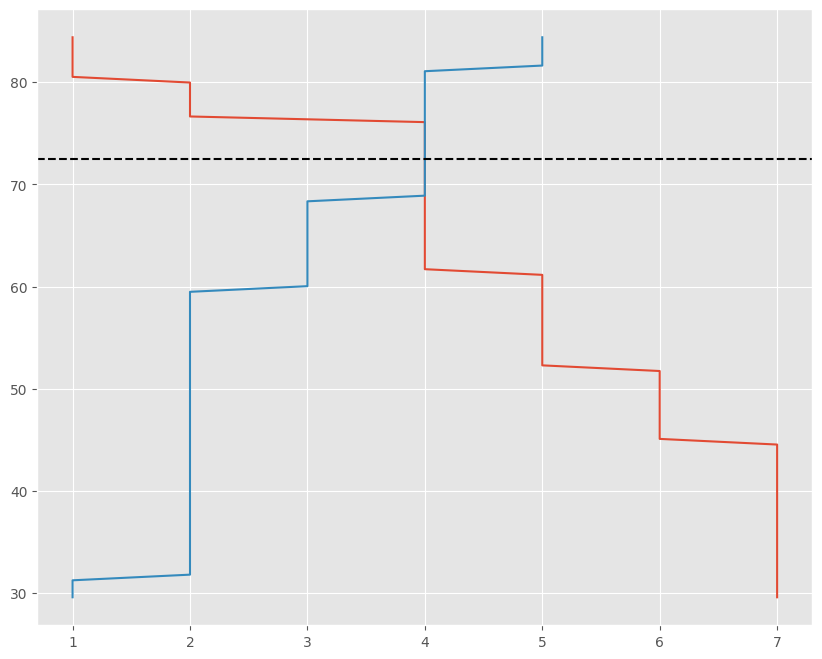

In [3]:
display(db.step_data.head(250).groupby('current_bid_idx').sum())
display(db.step_data.tail(250).groupby('current_bid_idx').sum())
display(db.step_data.head(250).groupby('current_ask_idx').sum())
display(db.step_data.tail(250).groupby('current_ask_idx').sum())
graph_period(env.db, 0, 1)
graph_period(env.db, 0, 49)

In [ ]:
env.db.round_data.redemption_values.item()
env.db.round_data.token_costs.item()
env.db.round_data.redemption_values.item()
env.db.round_data.token_costs.item()



In [ ]:
graph_period(env.db, 0, 45)

In [ ]:
graph_period(env.db, 0, 1)

In [ ]:
graph_period(env.db, 0, 2)

In [ ]:
graph_period(env.db, 0, 5)

In [ ]:
graph_period(env.db, 0, 45)

In [ ]:
env.db.step_data.iloc[-74:-25]

In [ ]:
db.round_data.redemption_values.item()

In [ ]:
db.round_data.token_costs.item()